In [ ]:
# Feature Reduction Candidates: 'age' and 'height_m'
# Based on our EDA, the following variables may be considered for removal due to limited predictive value:

# 1. 'age':
#    - Shows a slight increase with higher obesity levels, but with significant overlap across all categories.
#    - Likely adds little discriminative power in KNN's distance-based calculations.

# 2. 'height_m':
#    - Varies very little across obesity levels.
#    - Since 'weight_kg' already captures size-related information, 'height_m' may be redundant or uninformative.

# We could test KNN performance without these variables in a second step to determine whether excluding them improves model simplicity
# without sacrificing accuracy.

## Imports

In [5]:
# Load required libraries

import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [6]:
# Define target and features
y = df["obesity_level"]
X = df.drop(columns=["obesity_level"])

# Load the dataset
# Load data
file_path = os.path.join("..", "processed_data", "obesity_cleaned.feather")
df = pd.read_feather(file_path)

## Train Test Split

In [7]:
#Split the dataset 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Define encoding strategy 

Before applying K-Nearest Neighbors (KNN), we manually encoded categorical variables to preserve their structure and ensure compatibility with distance-based calculations.

Binary variables (e.g., gender, smoking) were mapped to 0/1 for clarity and consistency. Ordinal variables (e.g., vegetable intake, physical activity) were encoded using ordered levels to reflect meaningful progression (e.g., "Never" < "Sometimes" < "Always"). This is essential for KNN, which relies on distances between numeric values.

Encoding before scaling is crucial: scaling assumes numerical values carry meaningful distances. While ordinal steps may not be perfectly equidistant, preserving their order is far better than treating them as nominal.

Ordinal encoding is also valuable because it avoids inflating the feature space. Unlike one-hot encoding, which creates multiple new columns per variable, ordinal encoding keeps dimensionality low — which is particularly important for KNN, as high-dimensional spaces can dilute the relevance of distance metrics ("curse of dimensionality").

In [8]:
binary_map = {
    "gender": {"Female": 0, "Male": 1},
    "family_history_overweight": {"yes": 1, "no": 0},
    "high_caloric_food_freq": {"yes": 1, "no": 0},
    "smokes": {"yes": 1, "no": 0},
    "calorie_tracking": {"yes": 1, "no": 0},
}

ordinal_mappings = {
    "vegetables_freq": ["Never", "Sometimes", "Always"],
    "main_meal_count": ["Between 1 y 2", "Three", "More than three"],
    "snacking_freq": ["no", "Sometimes", "Frequently", "Always"],
    "water_intake": ["Less than a liter", "Between 1 and 2 L", "More than 2 L"],
    "physical_activity_freq": ["I do not have", "1 or 2 days", "2 or 4 days", "4 or 5 days"],
    "screen_time_hours": ["0-2 hours", "3-5 hours", "More than 5 hours"],
    "alcohol_consumption_freq": ["no", "Sometimes", "Frequently", "Always"]
}

## Apply the Encoding to Both Train and Test Data

In [12]:
# Apply binary mapping to the binary columns
X_train = X_train.replace(binary_map)
X_test = X_test.replace(binary_map)

# Apply ordinal mapping to the ordinal columns
for col, order in ordinal_mappings.items():
    encoder = OrdinalEncoder(categories=[order])
    X_train[col] = encoder.fit_transform(X_train[[col]])
    X_test[col] = encoder.transform(X_test[[col]])


## Drop columns we don't want to use

We considered one-hot encoding the transport_mode variable, but this would have added multiple sparse features to our dataset. Since our EDA revealed only weak correlations between transport mode and obesity level, we opted to drop this variable. This helps reduce dimensionality and avoids diluting the distance metric used by KNN.

In [16]:
X_train = X_train.drop(columns=["transport_mode"])
X_test = X_test.drop(columns=["transport_mode"])

## Scale the Numerical and Ordinal Data

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# quick check of the scaled data
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled_df.head()

,gender,age,height_m,weight_kg,family_history_overweight,high_caloric_food_freq,vegetables_freq,main_meal_count,snacking_freq,smokes,water_intake,calorie_tracking,physical_activity_freq,screen_time_hours,alcohol_consumption_freq
0,-1.013119,-0.532646,-0.768029,-1.019413,0.469612,0.355083,0.979868,0.237445,3.886490,6.502465,-0.016466,-0.214123,1.133519,-0.980788,0.525657
1,-1.013119,-0.544235,0.546078,1.802127,0.469612,0.355083,0.979868,0.237445,-0.302779,-0.153788,1.446407,-0.214123,0.002680,0.516111,0.525657
2,-1.013119,-0.239258,-0.427896,-0.153398,0.469612,0.355083,-2.419962,-1.766588,-0.302779,-0.153788,1.446407,-0.214123,-1.128159,2.013009,0.525657
3,-1.013119,-0.403229,-1.217973,-1.623588,-2.129419,-2.816242,0.979868,-1.766588,1.791856,-0.153788,1.446407,-0.214123,0.002680,-0.980788,-1.411698
4,0.987051,0.238722,1.179597,0.745216,0.469612,0.355083,0.979868,0.237445,-0.302779,-0.153788,1.446407,-0.214123,1.133519,0.516111,0.525657


## Tune k for KNN (No PCA)

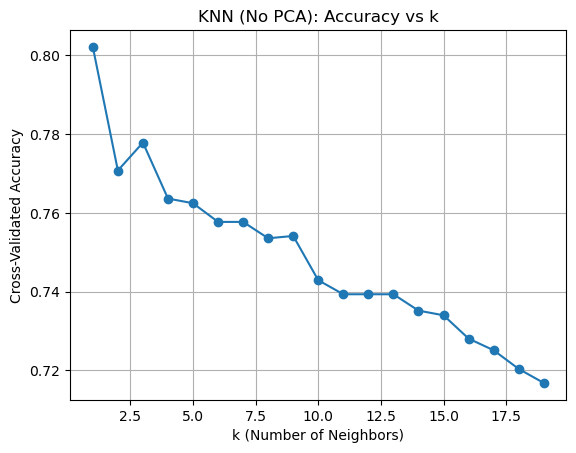

Best k (no PCA): 1, Test Accuracy: 0.7754


In [33]:
# Tune k using 5-fold CV
k_values = range(1, 20)
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5)
    cv_scores.append(scores.mean())

# Plot CV accuracy vs k
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('KNN (No PCA): Accuracy vs k')
plt.grid(True)
plt.show()

# Pick best k and evaluate on test set
best_k = k_values[np.argmax(cv_scores)]
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train_scaled, y_train)
test_acc_knn = knn_final.score(X_test_scaled, y_test)
print(f"Best k (no PCA): {best_k}, Test Accuracy: {test_acc_knn:.4f}")

## Final KNN with Best k (No PCA)

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

pipe = Pipeline([
    ('pca', PCA()),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'pca__n_components': [5, 10, 15],  # Or fix to a value if you prefer
    'knn__n_neighbors': range(1, 21)
}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train_scaled, y_train)

# Best model and its test accuracy
best_model = grid.best_estimator_
test_acc_pca_knn = best_model.score(X_test_scaled, y_test)

print(f"Best k (with PCA): {grid.best_params_['knn__n_neighbors']}, "
      f"n_components: {grid.best_params_['pca__n_components']}, "
      f"Test Accuracy: {test_acc_pca_knn:.4f}")

Best k (with PCA): 1, n_components: 15, Test Accuracy: 0.7754


The best test accuracy with PCA turned out to be identical to the result without PCA (0.7754).  
This indicates that the selected number of principal components (15) preserved nearly all the variance from the original feature space.  
In other words, PCA did not meaningfully reduce the information content in the data, which explains why model performance remained unchanged.  

### Feature Exclusion: Weight, Height, and Age

In this section, I excluded the features `weight_kg`, `height_m`, and `age` from the KNN model based on both theoretical and empirical considerations.

#### 1. Excluding `weight_kg` and `height_m`

The target variable `obesity_level` is directly derived from the Body Mass Index (BMI), calculated as:

${BMI} = \frac{\text{weight (kg)}}{(\text{height (m)})^2}$

Including either `weight_kg` or `height_m` would effectively leak information used to define the target itself into the model. This introduces circular reasoning and undermines the goal of assessing which features are genuinely predictive. For this reason, both were excluded to preserve the validity of the modeling exercise.

#### 2. Excluding `age`

The EDA revealed that while age shows **mild variation** across obesity categories, the overall distribution is skewed toward younger individuals (late teens to late twenties), and there's substantial **overlap across all obesity levels**. Boxplots confirmed that age may be only a **secondary predictor at best**, contributing little to the discriminative power of a KNN model. Therefore, age was also excluded in order to focus on features that may offer more actionable insight.

#### Policy Implications

From a public policy perspective, it may be more meaningful to focus prediction efforts on **behavioral and lifestyle features**—such as dietary habits, physical activity, and screen time—rather than biometric variables like weight or age. These lifestyle variables are not only more **modifiable** through interventions but also more **accessible** through self-reported surveys or digital tools. Models that can predict obesity risk based on these factors may help design **targeted preventive strategies** and promote **healthier behaviors** across populations.

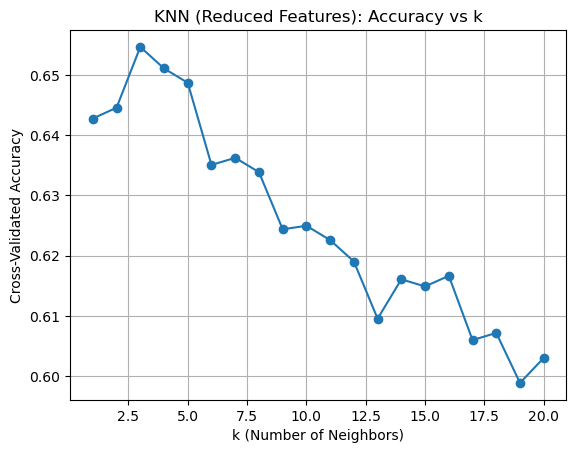

Best k (reduced): 3, Test Accuracy: 0.5934


In [43]:
### 1. Drop 'age' and 'height_m' from the training and test sets
X_train_reduced = X_train.drop(columns=['height_m', 'weight_kg', 'age'])
X_test_reduced = X_test.drop(columns=['height_m', 'weight_kg', 'age'])

### 2. Scale the reduced feature sets
scaler = StandardScaler()
X_train_reduced_scaled = scaler.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler.transform(X_test_reduced)

### 3. Tune k again using 5-fold CV on the reduced set
cv_scores_reduced = []
k_values = range(1, 21)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_reduced_scaled, y_train, cv=5)
    cv_scores_reduced.append(scores.mean())

### 4. Plot the new CV results
plt.plot(k_values, cv_scores_reduced, marker='o')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('KNN (Reduced Features): Accuracy vs k')
plt.grid(True)
plt.show()

### 5. Fit final model with best k and evaluate on test set
best_k_reduced = k_values[np.argmax(cv_scores_reduced)]
knn_final_reduced = KNeighborsClassifier(n_neighbors=best_k_reduced)
knn_final_reduced.fit(X_train_reduced_scaled, y_train)
test_acc_reduced = knn_final_reduced.score(X_test_reduced_scaled, y_test)

print(f"Best k (reduced): {best_k_reduced}, Test Accuracy: {test_acc_reduced:.4f}")
